In [133]:
import numpy as np
import matplotlib.pyplot as plt

import math
import scipy.sparse as sps

from scipy.sparse.linalg import cg
from scipy.integrate import odeint

from fastprogress import progress_bar

import jlinops
import sampi


# Test problem

In [141]:
ground_truth = jlinops.graecolatinsquare(which=5) + 1.0
img_shape = ground_truth.shape
L = 10
n = math.prod(ground_truth.shape)
mask = np.random.binomial(1, p=0.7, size=img_shape) # Random mask
A = jlinops.Subsampling2DOperator(mask)
#A = jlinops.IdentityOperator( (n,n) )
np.random.seed(0)
noisy_signal = A.matvec(ground_truth.flatten())*np.random.gamma(shape=L, scale=1/L, size=A.shape[0])

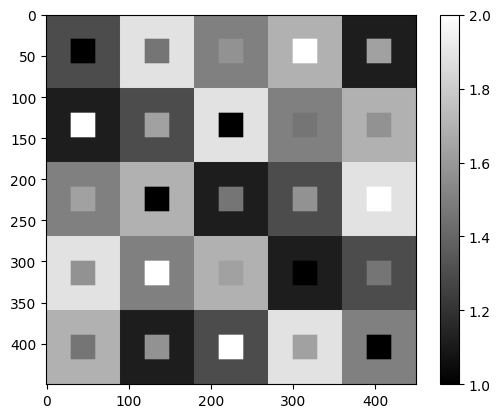

In [142]:
plt.imshow(ground_truth, cmap="gray")
plt.colorbar()
plt.show()

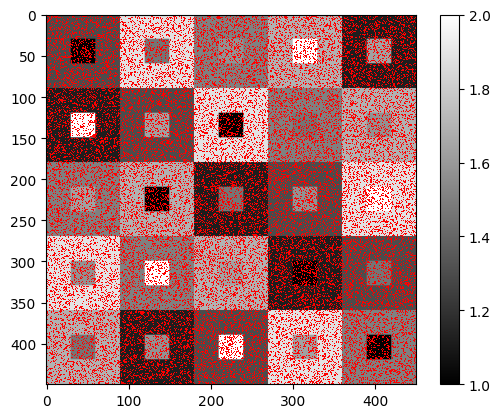

In [143]:
from matplotlib.colors import ListedColormap

# Example grayscale image and binary mask
image = ground_truth  # Replace this with your grayscale image

# Create a colormap: 0 -> transparent, 1 -> red
cmap = ListedColormap([(0,0,0,0), (1,0,0,1)]) # RGBA: (Red, Green, Blue, Alpha)

plt.imshow(image, cmap='gray')  # Display the grayscale image
plt.colorbar()
plt.imshow(1 - mask, cmap=cmap)     # Overlay the mask
plt.show()

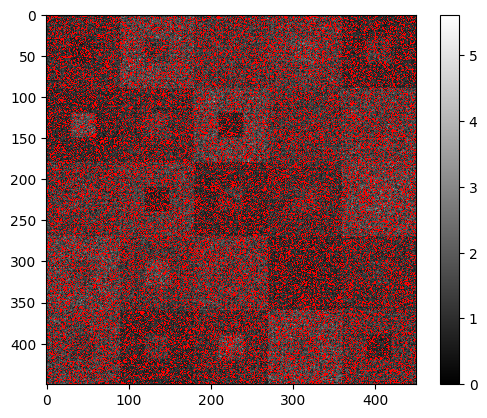

In [144]:
cmap = ListedColormap([(0,0,0,0), (1,0,0,1)]) # RGBA: (Red, Green, Blue, Alpha)
plt.imshow(  A.rmatvec(noisy_signal).reshape(img_shape) , cmap="gray")
plt.colorbar()
plt.imshow(1 - mask, cmap=cmap)
plt.show()

# Solver

In [145]:

class DespecklingIASSolver:
    """Implements a block coordinate descent solver for the 
    despeckling problem.
    """

    def __init__(self, A, R, f, hyperparams, L=1, pdata={}):

        # Bind
        self.f = f
        self.R = R
        self.A = A
        self.hyperparams = hyperparams
        self.L = L
        self.n = R.shape[1]
    
        # Some checks
        if not np.isscalar(self.hyperparams["prior"]["vartheta"]):
            assert len(self.hyperparams["prior"]["vartheta"]) == self.R.shape[0], "If vartheta is a vector, must be same size as output size of regularization operator."

      
        # Handle pdata
        self._pdata = pdata
        self.pdata = {
            "W": None,
            "Rpinv_factory": None,
            "Rinv": None,
            "FWpinv": None,
        }
        for key in self._pdata.keys():
            if key in ["W", "Rpinv_factory", "Rinv", "FWpinv"]:
                self.pdata[key] = self._pdata[key]
            else:
                raise ValueError
        
        # Some others
        self.m = self.n
        self.k = self.R.shape[0] # output size of regularization operator

        # Misc
        self.last_x = None
        self.last_xbar = None



    def solve(self, max_iters=100, u0=None, priorconditioning=False, x_update_solver_params={}, eps=1e-2, early_stopping=True, warmstarting=True):
        """Driver for the IAS solver.
        """
        
        # Handle initialization
        if u0 is None:
            u = np.ones(self.n)
        else:
            u = u0
        
        # Handle warmstarting
        if warmstarting:
            u_prev = u.copy()
        else:
            u_prev = None

        # Tracking
        self.nsolve = None
        n_cg_its_per_iteration = []
        obj_vals = []
        converged = False
        n_iters = 0
        newton_flags = []
        newton_iters = []
        
        # Iterate
        for j in progress_bar(range(max_iters)):
            
            # Update prior thetas
            theta_curr = self.theta_update(u)

            # Update u
            u, iters, flag = self.x_update(theta_curr, u0=u_prev, priorconditioning=priorconditioning, **x_update_solver_params)
            newton_flags.append(flag)
            newton_iters.append(iters)
            if warmstarting:
                u_prev = u.copy()
            # n_cg_its_per_iteration.append(n_cg_its)
            
            # Compute objective value
            obj_val = self.objective(u, theta_curr)
            obj_vals.append(obj_val)

            if (j > 0) and (early_stopping):
                converged = self.check_stopping_criterion(theta_prev, theta_curr, eps=eps)
                if converged:
                    break
                else:
                    pass
                
            # Advance
            theta_prev = theta_curr
            n_iters += 1


        data = {
            "u": u,
            "theta": theta_curr,
            "n_cg_its_per_iteration": np.asarray(n_cg_its_per_iteration),
            "converged": converged,
            "obj_vals": np.asarray(obj_vals),
            "n_iters": n_iters,
            "newton_iters": newton_iters,
            "newton_flags": newton_flags,
        }

        return data



    def x_update(self, theta, u0, priorconditioning=False, **kwargs):
        """Returns the x-update for fixed local variance parameters theta.
        Solves a nonlinear equation using newton's method.
        """

        # Build Rtilde
        Rtilde = jlinops.DiagonalOperator(1.0/np.sqrt(theta)) @ self.R

        if not priorconditioning:

            # Call projected Newton-Krylov solver
            newton_data = sampi.despeckling_newton_krylov(self.A, self.R, theta, self.L, self.f, u0=u0, **kwargs)

            return newton_data["u"], newton_data["n_iters"], newton_data["converged"]



        else:

            # Build current Rpinv operator
            Rpinv = self.pdata["Rpinv_factory"](theta)

            #despeckling_priorconditioned_newton_krylov

            newton_data = sampi.despeckling_priorconditioned_newton_krylov(self.f, self.L, self.A, Rtilde, Rpinv, self.pdata["W"], u0=u0, **kwargs)

            return newton_data["u"], newton_data["n_iters"], newton_data["converged"]
          

            # # Build current Rpinv operator
            # Rpinv = self.pdata["Rpinv_factory"](theta)

            # newton_data = sampi.log_despeckling_priorconditioned_newton_krylov(self.y, self.L, Rtilde, Rpinv, self.pdata["W"], x0=x0, **kwargs)

            # return newton_data["x"], newton_data["n_iters"], newton_data["converged"]



        
    def theta_update(self, u):
        """Returns the theta-update for fixed x.
        """

        r, beta, vartheta = self.hyperparams["prior"]["r"], self.hyperparams["prior"]["beta"], self.hyperparams["prior"]["vartheta"]
        eta = r*beta - 1.5
        initial_value = (eta/r)**(1/r)

        # Rescale
        z = np.abs(  ( self.R @ (u) )  / np.sqrt(vartheta) )

        # If r = 1, use exact formula
        if abs(r - 1) < 1e-5:    
                # print("Using exact formula for r = 1")
                xi = 0.5*( eta + np.sqrt( (eta**2) +  2*(z**2)  ) )
                new_theta = vartheta*xi
                
                return new_theta

        elif abs(r + 1) < 1e-5:
                
                # print("Using exact formula for r = -1")
                
                k = beta + 1.5
                xi = (1/(2*k)) * ( (z**2) + 2 )
                new_theta = vartheta*xi
                
                return new_theta

        # Otherwise, solve using the ODE method
        else:
            
            #print("Using ODE method")
            assert ((r < 0) and (eta < -1.5)) or ( (r > 0) and (eta > 0) ), "invalid parameter combination for ODE method."
            
            final_times = z

            # Sort the final times
            argsort = final_times.argsort()
            final_times_sorted = final_times[argsort]

            # We need to prepend zero to this for the solver
            final_times_sorted = np.insert(final_times_sorted, 0, 0)

            # Now solve the ODE
            ode_sol = odeint(self._conditional_mode_ode_rhs,
                                np.atleast_1d(initial_value), 
                                final_times_sorted,
                                args=(r,) # r parameter
                            )

            # Reshape and drop the first value corresponding to the dummy initial value
            ode_sol = ode_sol[1:,0]

            # Now back out the updated value of the hyper-parameter
            xi = np.zeros_like(final_times)
            xi[argsort] = ode_sol
            new_theta = vartheta*xi

            return new_theta


    def _conditional_mode_ode_rhs(self, varphi, z, r):
        """RHS of the ODE used for updating theta.
        """
        
        dvarphidz = (2*z*varphi)/((2*(r**2)*((varphi)**(r+1))) + (z**2))

        return dvarphidz
    
    
    
    def objective(self, u, theta):
        """Evaluates the objective function.
        """
        
        r, beta, vartheta = self.hyperparams["prior"]["r"], self.hyperparams["prior"]["beta"], self.hyperparams["prior"]["vartheta"]
        eta = (r*beta) - 1.5

        # Assemble terms
        Au = self.A.matvec(u)
        gamma_likelihood = self.L*(np.log( Au ).sum() + (self.f/Au).sum())
        cond_pr = 0.5*((np.linalg.norm( (1.0/np.sqrt(theta))*(self.R @ u)  ))**2)
        hyperpr = ((theta/vartheta)**(r)).sum() - eta*(np.log(theta)).sum()
        
        # Sum together
        obj = gamma_likelihood + cond_pr + hyperpr
        
        return obj

    
    
    def check_stopping_criterion(self, theta_prev, theta_curr, eps=1e-3):
        """Our stopping criterion is whenever the relative norm change in thetas (and noise var, if applicable)
        falls below eps, but each separately (unanimous vote).
        """
        
        theta_check = (np.linalg.norm(theta_curr - theta_prev)/np.linalg.norm(theta_prev)) < eps
       
        if theta_check:
            return True
        else:
            return False
        



# Test

In [151]:
W = np.ones(n)
W = jlinops.MatrixLinearOperator(W)

# R = jlinops.Neumann2D(img_shape)
# Rpinv_factory = lambda theta: jlinops.CGWeightedNeumann2DPinvOperator(img_shape, 1.0/np.sqrt(theta), which="scipy", tol=1e-1)

_R, W = jlinops.first_order_derivative_2d(img_shape, boundary="none")
W = jlinops.MatrixLinearOperator(W)
_R = jlinops.MatrixLinearOperator(_R)
def Rpinv_factory(theta):
    Rtilde = jlinops.MatrixLinearOperator(sps.diags(1.0/np.sqrt(theta)) @ _R.A)
    op = jlinops.BandedCholeskyPinvOperator(Rtilde, delta=1e-3)
    print("Finished cholesky!")
    return op

R = jlinops.Neumann2D(img_shape)

pdata = {}

pdata = {
    "W": W,
    "Rpinv_factory": Rpinv_factory,
}

In [152]:
# Rpinv_factory(np.ones(R.shape[0]))

In [172]:
# Prior parameters
reg_lambda =0.2*1e1
vartheta = 2/(reg_lambda**2)
hyperparams = {
    "prior": {
        "r": 1.0,
        "beta": 1.5 + 1e-2,
        "vartheta": vartheta,
    },
}

# hyperparams = {
#     "prior": {
#         "r": -1,
#         "beta": 1,
#         "vartheta": 1e-1,
#     },
# }

# Create solver
solver = DespecklingIASSolver(A, R, noisy_signal, hyperparams, L=L, pdata=pdata)

In [203]:
print(vartheta)

0.5


In [174]:
priorconditioning = False
x_update_solver_params = {
    "newton_maxiter": 40,
    "newton_tol": 1e-3,
    "cg_tol": 1e-3,
    "cg_maxiter": None,
    "backtrack_alpha": 0.1,
    "backtrack_beta": 0.7,
    "search_maxiter": 100,
}

# priorconditioning = True
# x_update_solver_params = {
#     "newton_maxiter": 40,
#     "newton_tol": 1e-3,
#     "tol": 1e-7,
#     "maxiter": None,
#     "backtrack_alpha": 0.4,
#     "backtrack_beta": 0.9,
#     "search_maxiter": 100,
# }

data2 = solver.solve(max_iters=50, u0=ground_truth.flatten(), warmstarting=True, eps=1e-3, early_stopping=True,
                    x_update_solver_params=x_update_solver_params, priorconditioning=priorconditioning)

5
4
4


KeyboardInterrupt: 

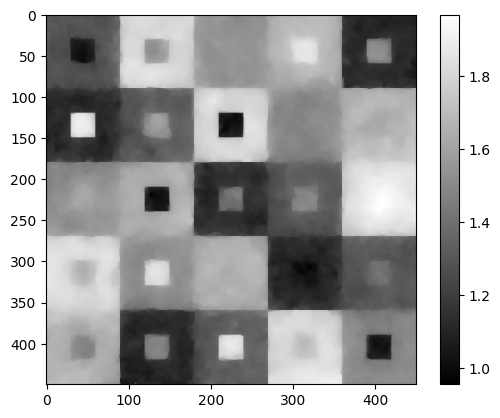

In [175]:
plt.imshow(data2["u"].reshape(img_shape), cmap="gray")
plt.colorbar()
plt.show()

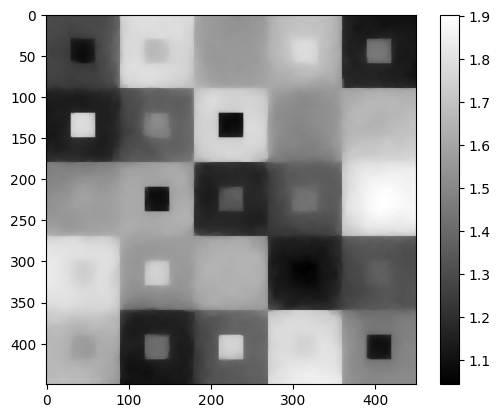

In [177]:
plt.imshow(data["u"].reshape(img_shape), cmap="gray")
plt.colorbar()
plt.show()

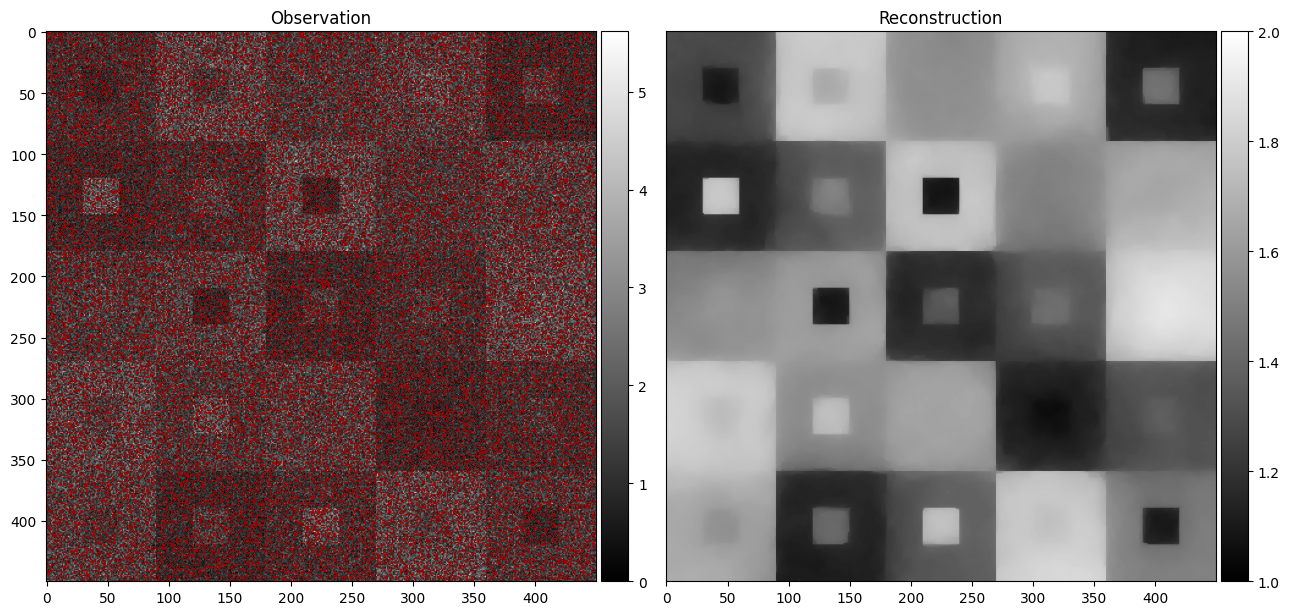

In [202]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1,2,figsize=(13,8))

# Function to adjust colorbar
def add_colorbar(im, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)


cmap = ListedColormap([(0,0,0,0), (1,0,0,1)]) # RGBA: (Red, Green, Blue, Alpha)
im1 = axs[0].imshow(  A.rmatvec(noisy_signal).reshape(img_shape) , cmap="gray")
add_colorbar(im1, axs[0])
axs[0].imshow(1 - mask, cmap=cmap, alpha=0.6)
axs[0].set_title("Observation")

im2 = axs[1].imshow(data["u"].reshape(img_shape), cmap="gray", vmin=1, vmax=2)
add_colorbar(im2, axs[1])
axs[1].set_yticks([])
axs[1].set_title("Reconstruction")

fig.tight_layout()

fig.savefig("square_example.png", dpi=400, bbox_inches='tight', pad_inches=0.1)

plt.show()

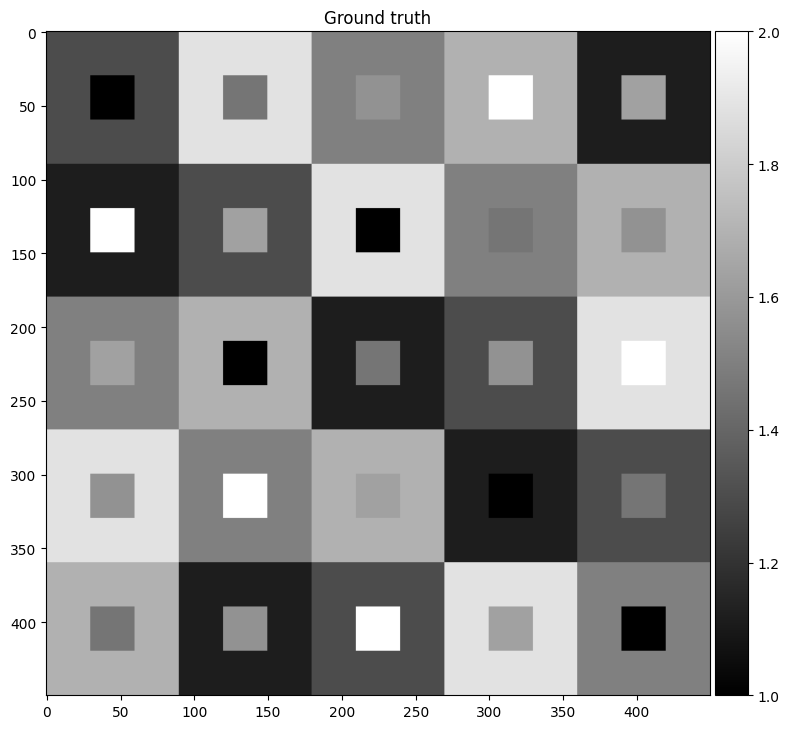

In [201]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1,1,figsize=(8,8))

# Function to adjust colorbar
def add_colorbar(im, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)


cmap = ListedColormap([(0,0,0,0), (1,0,0,1)]) # RGBA: (Red, Green, Blue, Alpha)
im1 = axs.imshow(  ground_truth , cmap="gray")
add_colorbar(im1, axs)
# axs.imshow(1 - mask, cmap=cmap, alpha=0.6)
# axs[0].set_title("Observation")

# im2 = axs[1].imshow(data["u"].reshape(img_shape), cmap="gray", vmin=1, vmax=2)
# add_colorbar(im2, axs[1])
# axs[1].set_yticks([])
# axs[1].set_title("Reconstruction")

axs.set_title("Ground truth")

fig.tight_layout()

fig.savefig("ground_truth_square.png", dpi=400)

plt.show()

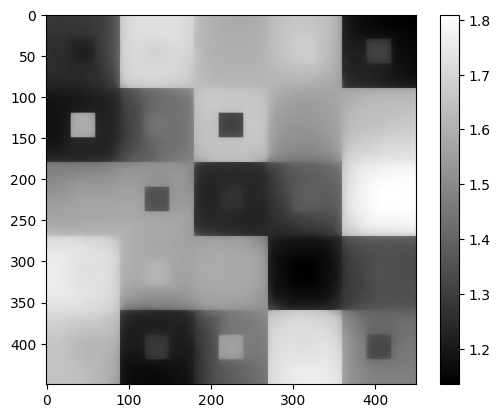

In [160]:
plt.imshow(data["u"].reshape(img_shape), cmap="gray")
plt.colorbar()
plt.show()

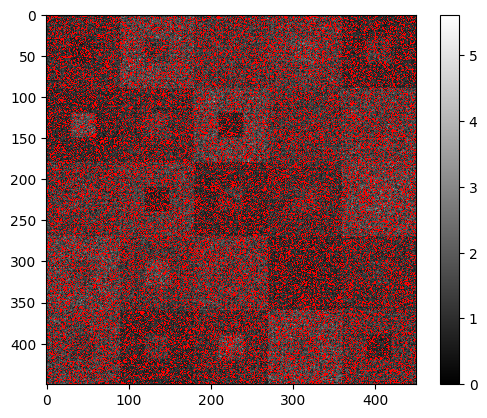

In [162]:
cmap = ListedColormap([(0,0,0,0), (1,0,0,1)]) # RGBA: (Red, Green, Blue, Alpha)
plt.imshow(  A.rmatvec(noisy_signal).reshape(img_shape) , cmap="gray")
plt.colorbar()
plt.imshow(1 - mask, cmap=cmap)
plt.show()